# Turn and Stop Sign Classification using NN

- Author: Yiran Jing
- Date: 28 Sep 2020
- Version: 1 (try basic four classes with images collected from signed map on 28 Sep)

## Content 
1. **EDA**
2. **Feature Engineering**
    1. Configure the dataset for performance
    2. Standardize the data
3. **Train model**
    1. 20% as test data, 80% as train data
    2. three convolution blocks
4. **Model evaluation**
    1. Confusion Matrix
    2. Classification report for each class
       - The overall accuracy is 100%
       - The model performance very well in left, right, stop, and other. (The error of misclassification is 0)
       - But note that it is highly likely that our model is `overfiting`.
       - And since the model looks ok under the main class, we can try including more classes (or also consider sub-classes)
       

5. Appendix 1: Adjusting overfit by Dropout, augmented images, and recrease epochs
    - Not useful currently
6. Appendix 2: Visualization data augmented examples

***
### Dataset description
The data within folder `signs_color_filtered`, and the data was collectted by donkey car simulator and online resources. 

- Four Main Class: `right-turn`, `left-turn`, `stop`, and `other` sign
- The dataset include `271` images
  - 108 colored left turn images
  - 0 colored right turn images
  - 79 colored stop images
  - 84 colored other signs

***


#### Key Limitation of this model
1. Not enough images, and unbalanced dataset
   - Will have more data in the following weeks
2. NN without any hyper-parameter turning
4. No data cleaning and feature engineering
   - Will try to create a valuable dataset is as important as training model
4. No feature engineering
   - Create a valuable dataset is as important as training model

In [8]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Load dataset and visualization

In [21]:
foler = "signed_map_test_28Sep"

In [22]:
path = foler+"/train/stop"
stop_image_count = len(listdir(path))
print("There are {} colored stop turn images.".format(stop_image_count))
path = foler+"/train/other"
other_image_count = len(listdir(path))
print("There are {} colored other turn images.".format(other_image_count))
path = foler+"/train/left"
left_image_count = len(listdir(path))
print("There are {} colored left turn images.".format(left_image_count))
#path = foler+"/train/right"
#right_image_count = len(listdir(path))
#print("There are {} colored right turn images.".format(right_image_count))

There are 79 colored stop turn images.
There are 84 colored other turn images.
There are 108 colored left turn images.


In [23]:
data_dir = pathlib.Path(foler+"/train")
#image_count = len(list(data_dir.glob('*/*.png')))
image_count = len(list(data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of turning images are {} ".format(image_count))

The total number of turning images are 271 


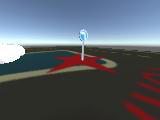

In [24]:
left = list(data_dir.glob('left/*'))
PIL.Image.open(str(left[0]))

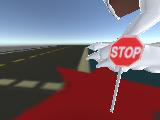

In [25]:
stop = list(data_dir.glob('stop/*'))
PIL.Image.open(str(stop[0]))

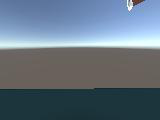

In [26]:
other = list(data_dir.glob('other/*'))
PIL.Image.open(str(other[0]))

In [27]:
# Predefined Hyper-parameter 
learning_rate = 0.001
batch_size = 64

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% as testing data
  subset="training",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=batch_size)

Found 270 files belonging to 3 classes.
Using 216 files for training.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=batch_size)

Found 270 files belonging to 3 classes.
Using 54 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names) # we only consider 2 classes here.

['left', 'other', 'stop']


#### Visualization training data

before we train the model, let's firstly, visualize some training data

From image below, we can see that 

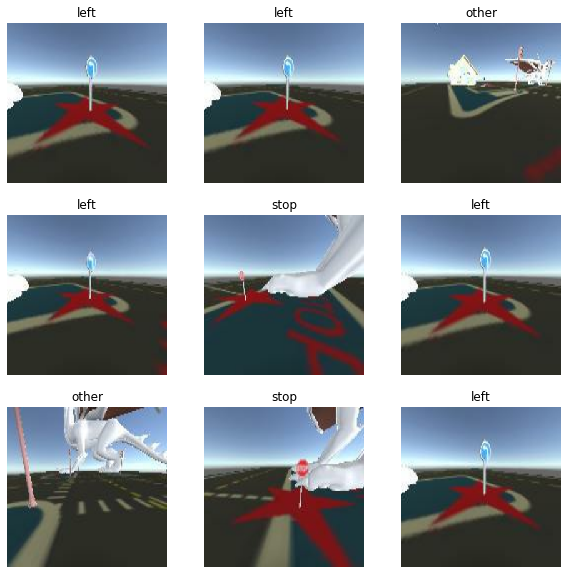

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


The `image_batch` is a tensor of the shape `(42, 256, 256, 3)`. This is a batch of 42 images of shape `256x256x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(42,)`, these are corresponding labels to the 32 images. 

In [47]:
img_height = 256
img_width = 256

### Feature Engineering
1. Configure the dataset for performance
2. Standardize the data


#### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data
The RGB channel values are in the `[0, 255]` range. 
We standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [49]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [50]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.025065105 1.0


### Train Model

The model consists of three `convolution blocks` with a `max pool layer` in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, just randomly selected

`relu = max(0, x)`. 

In [51]:
def train_Visualize_CNN(model, 
                        epochs,
                        train_ds, val_ds):
            
    # model compile
    # using Adam optimizer
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            
        
    print(model.summary())
    
    #train model     
    cnn_history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs
        )
    
    return cnn_history

In [52]:
num_classes = 3
epochs = 7
cnn_1 = Sequential([
          #data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          #layers.Dropout(drop_out), # drop out rate
          layers.Flatten(),
          layers.Dense(128, activation='relu'), # 学习研究这里面不会的东西！然后改进
          layers.Dense(num_classes)
            ])

cnn_history_1 = train_Visualize_CNN(cnn_1,
                            epochs, 
                            train_ds = train_ds, 
                            val_ds = val_ds)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)       

In [53]:
def plot_train_result(model_result, epoch):
    acc = model_result.history['accuracy']
    val_acc = model_result.history['val_accuracy']

    loss=model_result.history['loss']
    val_loss=model_result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Visualize results

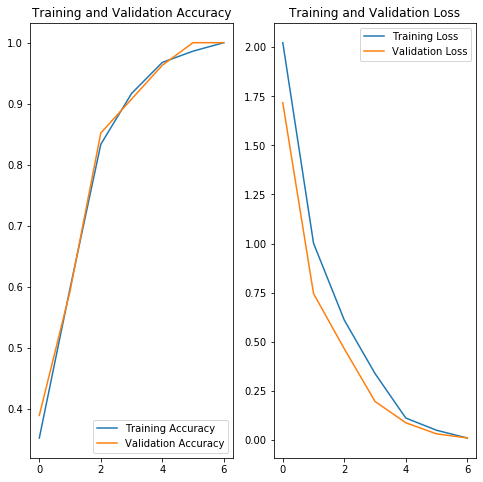

In [54]:
plot_train_result(cnn_history_1, epochs)

From the plot above, we can see that the test accuracy is increasing and then decreasing around epoch = 4. 

## Model evaluation

Reason to add confusion matrix: We select model based on accuracy, but accuracy is just a summary of all classes performance, so to see individual class performance, we should draw confusion matrix. Also, it is good to consider Precision Recall, ROC for each classes.

### Confusion Matrix

In [55]:
def plot_normalized_confusion_matrix(y_test, y_pred, title, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    target_names = class_names
    fig, ax = plt.subplots(figsize=(8,5))
    fig.suptitle(title,fontsize=20)
    ax.set_xlabel("Preidicted_Label")
    ax.set_ylabel('True_Label')
    plt.xticks(np.arange(0, 60), np.arange(1,60))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, 
            yticklabels=target_names, linewidths=.8,)
    #image_path = 'image/' + model +'_normalized_confusion_matrix.png'
    #fig.savefig(image_path)   
    #plt.close(fig)
    plt.show()  


In [56]:
def draw_confusion_matrix(model, val_ds):
    #Confution Matrix and Classification Report
    num_of_test_samples = 31
    Y_pred = model.predict(val_ds)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix, x label is Predicted_Label, y is True_Label')
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    plot_normalized_confusion_matrix(y_true, y_pred, "Normalized Confusion Matrix", class_names) # self-defined function
    
    print('\n\nClassification Report bazed on validation data')
    #target_names = train_ds.class_names
    target_names = class_names
    print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix, x label is Predicted_Label, y is True_Label


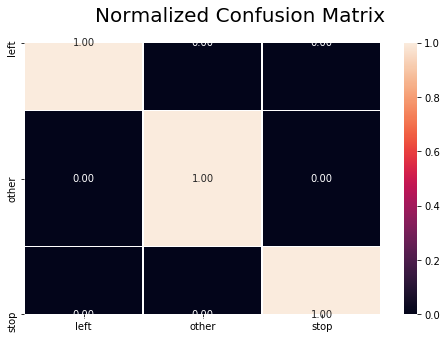



Classification Report bazed on validation data
              precision    recall  f1-score   support

        left       1.00      1.00      1.00        26
       other       1.00      1.00      1.00        16
        stop       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [57]:
draw_confusion_matrix(cnn_1, val_ds)

- The overall accuracy is 100%
- The model performance very well in left, right, stop, and other. (The error of misclassification is 0)
- But note that it is highly likely that our model is `overfiting`.
- And since the model looks ok under the main class, we can try including more classes (or also consider sub-classes)

### Appendix: Deal with Overfitting (Unuseful currently)
Create a new neural network using layers.Dropout, then train it using augmented images.
Here, try:
- *data augmentation* 
- add *Dropout* 

#### 1. Decreate the number of epoches


#### 1. Data augmentation

Generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

#### 2. Dropout
A form of regularization. It randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.


In [25]:
### Visualization data augmented examples

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = 2
epochs = 10
cnn_2 = Sequential([
          data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2), # drop out rate 
          layers.Flatten(),
          layers.Dense(128, activation='relu'), # 不懂 16 32 64 128这些是怎么来的 什么逻辑
          layers.Dense(num_classes)
            ])

cnn_2 = train_Visualize_CNN(cnn_2,
                            epochs, 
                            train_ds = train_ds, 
                            val_ds = val_ds)

In [ ]:
plot_train_result(cnn_2, epochs)

### Appendix: Visualization data augmented examples

visualize what a few augmented examples look like by applying data augmentation to the same image several times

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")